In [1]:
!pip install -U "tensorflow-text==2.13.*"
!pip install "tf-models-official==2.13.*"

In [2]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow import keras

from tensorflow.keras.metrics import F1Score
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import AdamW

In [3]:
!gdown 15gONUEFE5FtKmZaxaKP6rTyTmxJRF_2s

Downloading...
From (original): https://drive.google.com/uc?id=15gONUEFE5FtKmZaxaKP6rTyTmxJRF_2s
From (redirected): https://drive.google.com/uc?id=15gONUEFE5FtKmZaxaKP6rTyTmxJRF_2s&confirm=t&uuid=40754b23-5a40-453f-a6b1-2ad2be186116
To: /content/data.zip
100% 98.4M/98.4M [00:00<00:00, 183MB/s]


In [4]:
!unzip -qq data.zip -d data

replace data/posters/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [35]:
from google.colab import drive
drive.mount('/content/drive')

ValueError: mount failed

In [ ]:
movies = pd.read_csv('./data/movies.dat', engine='python',
                     sep='::', names=['id', 'titles', 'genres'], encoding='latin-1', index_col=False).set_index('id')

movies['genres'] = movies.genres.str.split('|')
movies

In [6]:
idx = movies.index
titles_column_index = movies.columns.get_loc("titles")
movies.insert(titles_column_index, "idx", idx)

img_path = movies.apply(lambda x: os.path.join("./data/posters", f"{x.idx}.jpg"), axis = 1)
movies.insert(titles_column_index + 2, "img_path", img_path)
movies = movies[movies['img_path'].apply(os.path.isfile)]

movies['genres_string'] = movies.apply(lambda x: '[' + ', '.join(map(str, x.genres)) + ']', axis = 1)

movies

<ipython-input-6-8feb7d06bb76>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['genres_string'] = movies.apply(lambda x: '[' + ', '.join(map(str, x.genres)) + ']', axis = 1)


,idx,titles,img_path,genres,genres_string
id,,,,,
1,1,Toy Story (1995),./data/posters/1.jpg,"[Animation, Children's, Comedy]","[Animation, Children's, Comedy]"
2,2,Jumanji (1995),./data/posters/2.jpg,"[Adventure, Children's, Fantasy]","[Adventure, Children's, Fantasy]"
3,3,Grumpier Old Men (1995),./data/posters/3.jpg,"[Comedy, Romance]","[Comedy, Romance]"
4,4,Waiting to Exhale (1995),./data/posters/4.jpg,"[Comedy, Drama]","[Comedy, Drama]"
5,5,Father of the Bride Part II (1995),./data/posters/5.jpg,[Comedy],[Comedy]
...,...,...,...,...,...
3948,3948,Meet the Parents (2000),./data/posters/3948.jpg,[Comedy],[Comedy]
3949,3949,Requiem for a Dream (2000),./data/posters/3949.jpg,[Drama],[Drama]
3950,3950,Tigerland (2000),./data/posters/3950.jpg,[Drama],[Drama]


In [7]:
# There are some terms with occurrence as low as 1.
print(sum(movies["genres_string"].value_counts() == 1))

# How many unique terms?
print(movies["genres_string"].nunique())

129
297


In [8]:
movies = movies.groupby("genres_string").filter(lambda x: len(x) > 1)
movies = movies.drop(['genres_string'], axis=1)

import re
movies['titles'] = movies.apply(lambda row: re.compile(r'\s*\(\d{4}\)$').sub('', row.titles), axis = 1)
movies

,idx,titles,img_path,genres
id,,,,
1,1,Toy Story,./data/posters/1.jpg,"[Animation, Children's, Comedy]"
2,2,Jumanji,./data/posters/2.jpg,"[Adventure, Children's, Fantasy]"
3,3,Grumpier Old Men,./data/posters/3.jpg,"[Comedy, Romance]"
4,4,Waiting to Exhale,./data/posters/4.jpg,"[Comedy, Drama]"
5,5,Father of the Bride Part II,./data/posters/5.jpg,[Comedy]
...,...,...,...,...
3948,3948,Meet the Parents,./data/posters/3948.jpg,[Comedy]
3949,3949,Requiem for a Dream,./data/posters/3949.jpg,[Drama]
3950,3950,Tigerland,./data/posters/3950.jpg,[Drama]


In [9]:
# 10% for test
train_df, test_df = train_test_split(
    movies, test_size=0.15, stratify=movies["genres"].values, random_state=42
)

# Splitting the test set further into validation
# and new test sets.
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)


print(f"Total training examples: {len(train_df)}")
print(f"Total validation examples: {len(val_df)}")
print(f"Total test examples: {len(test_df)}")

Total training examples: 2657
Total validation examples: 235
Total test examples: 235


In [10]:
train_df["titles"].apply(lambda x: len(x.split(" "))).describe()

count    2657.000000
mean        3.012796
std         1.759822
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max        12.000000
Name: titles, dtype: float64

Multi-label Vocab

In [11]:
movies['genres'].values[:5]

array([list(['Animation', "Children's", 'Comedy']),
       list(['Adventure', "Children's", 'Fantasy']),
       list(['Comedy', 'Romance']), list(['Comedy', 'Drama']),
       list(['Comedy'])], dtype=object)

In [12]:
genres = tf.ragged.constant(movies["genres"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(genres)
vocab = lookup.get_vocabulary()


def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)


print("Vocabulary:\n")
print(vocab)

Vocabulary:

['[UNK]', 'Drama', 'Comedy', 'Action', 'Thriller', 'Romance', 'Horror', 'Sci-Fi', 'Adventure', "Children's", 'Crime', 'War', 'Musical', 'Animation', 'Mystery', 'Documentary', 'Western', 'Fantasy', 'Film-Noir']


In [13]:
sample_label = train_df['genres'][1]
lookup(tf.ragged.constant(train_df['genres'].values)).numpy().shape

(2657, 19)

Pre-processing Data

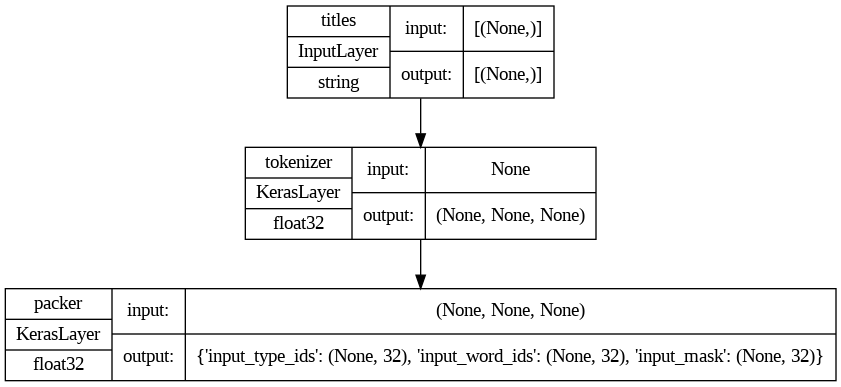

In [14]:
# Define TF Hub paths to the BERT encoder and its preprocessor
bert_model_path = (
    "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1"
)
bert_preprocess_path = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"


def make_bert_preprocessing_model(ft):
    """Returns Model mapping string features to BERT inputs.

  Args:
    sentence_features: A list with the names of string-valued features.
    seq_length: An integer that defines the sequence length of BERT inputs.

  Returns:
    A Keras Model that can be called on a list or dict of string Tensors
    (with the order or names, resp., given by sentence_features) and
    returns a dict of tensors for input to BERT.
  """

    input = tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft)

    bert_preprocess = hub.load(bert_preprocess_path)
    tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name="tokenizer")
    segment = [tokenizer(input)]

    packer = hub.KerasLayer(
        bert_preprocess.bert_pack_inputs,
        arguments=dict(seq_length=32),
        name="packer",
    )

    model_inputs = packer(segment)

    return keras.Model(input, model_inputs)


bert_preprocess_model = make_bert_preprocessing_model("titles")
keras.utils.plot_model(bert_preprocess_model, show_shapes=True, show_dtype=True)


In [15]:
idx = np.random.choice(len(train_df))
row = train_df.iloc[idx]
sample_text = row["titles"]
print(f"titles: {sample_text}")

test_text = [np.array([sample_text])]
text_preprocessed = bert_preprocess_model(test_text)

print("Keys           : ", list(text_preprocessed.keys()))
print("Shape Word Ids : ", text_preprocessed["input_word_ids"].shape)
print("Word Ids       : ", text_preprocessed["input_word_ids"])
print("Shape Mask     : ", text_preprocessed["input_mask"].shape)
print("Input Mask     : ", text_preprocessed["input_mask"])
print("Shape Type Ids : ", text_preprocessed["input_type_ids"].shape)
print("Type Ids       : ", text_preprocessed["input_type_ids"])

titles: Living in Oblivion
Keys           :  ['input_type_ids', 'input_word_ids', 'input_mask']
Shape Word Ids :  (1, 32)
Word Ids       :  tf.Tensor(
[[  101  2542  1999 24034   102     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0]], shape=(1, 32), dtype=int32)
Shape Mask     :  (1, 32)
Input Mask     :  tf.Tensor([[1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]], shape=(1, 32), dtype=int32)
Shape Type Ids :  (1, 32)
Type Ids       :  tf.Tensor([[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]], shape=(1, 32), dtype=int32)


In [16]:
resize = (299, 299)
bert_input_features = ["input_word_ids", "input_type_ids", "input_mask"]


def preprocess_image(image_path):
    extension = tf.strings.split(image_path)[-1]

    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, 3)
    image = tf.image.resize(image, resize)
    return image


def preprocess_text(title):
    title = tf.convert_to_tensor([title])
    output = bert_preprocess_model(title)
    output = {feature: tf.squeeze(output[feature]) for feature in bert_input_features}
    return output


def preprocess_text_and_image(sample):
    image = preprocess_image(sample["img_path"])
    title = preprocess_text(sample["titles"])
    return {"image": image, "title": title}

In [17]:
preprocess_image(row.img_path)

<tf.Tensor: shape=(299, 299, 3), dtype=float32, numpy=
array([[[3.5084206e+01, 4.2830021e+01, 4.0330856e+01],
        [5.8369732e-01, 3.2818317e+00, 2.2981491e+00],
        [1.7493881e+01, 9.7230053e+00, 1.1981764e+01],
        ...,
        [2.5174582e+02, 2.5174582e+02, 2.5174582e+02],
        [2.4377759e+02, 2.4377759e+02, 2.4377759e+02],
        [2.5273265e+02, 2.5273265e+02, 2.5273265e+02]],

       [[2.2365532e+02, 2.2391577e+02, 2.2441077e+02],
        [5.2580708e+01, 5.1579391e+01, 5.2071896e+01],
        [3.4074030e+00, 1.3808794e-01, 1.5067190e-01],
        ...,
        [2.3690393e+02, 2.3690393e+02, 2.3690393e+02],
        [2.5490884e+02, 2.5490884e+02, 2.5490884e+02],
        [2.5500000e+02, 2.5500000e+02, 2.5500000e+02]],

       [[2.5492685e+02, 2.5243057e+02, 2.5492180e+02],
        [2.1051904e+02, 2.0526530e+02, 2.0750488e+02],
        [6.3521248e+01, 6.0044273e+01, 6.1033859e+01],
        ...,
        [2.4527733e+02, 2.4527733e+02, 2.4527733e+02],
        [2.5495093e+02

In [18]:
preprocess_text(row.titles)

{'input_word_ids': <tf.Tensor: shape=(32,), dtype=int32, numpy=
 array([  101,  2542,  1999, 24034,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0], dtype=int32)>,
 'input_type_ids': <tf.Tensor: shape=(32,), dtype=int32, numpy=
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)>,
 'input_mask': <tf.Tensor: shape=(32,), dtype=int32, numpy=
 array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)>}

In [19]:
preprocess_text_and_image(row)

{'image': <tf.Tensor: shape=(299, 299, 3), dtype=float32, numpy=
 array([[[3.5084206e+01, 4.2830021e+01, 4.0330856e+01],
         [5.8369732e-01, 3.2818317e+00, 2.2981491e+00],
         [1.7493881e+01, 9.7230053e+00, 1.1981764e+01],
         ...,
         [2.5174582e+02, 2.5174582e+02, 2.5174582e+02],
         [2.4377759e+02, 2.4377759e+02, 2.4377759e+02],
         [2.5273265e+02, 2.5273265e+02, 2.5273265e+02]],
 
        [[2.2365532e+02, 2.2391577e+02, 2.2441077e+02],
         [5.2580708e+01, 5.1579391e+01, 5.2071896e+01],
         [3.4074030e+00, 1.3808794e-01, 1.5067190e-01],
         ...,
         [2.3690393e+02, 2.3690393e+02, 2.3690393e+02],
         [2.5490884e+02, 2.5490884e+02, 2.5490884e+02],
         [2.5500000e+02, 2.5500000e+02, 2.5500000e+02]],
 
        [[2.5492685e+02, 2.5243057e+02, 2.5492180e+02],
         [2.1051904e+02, 2.0526530e+02, 2.0750488e+02],
         [6.3521248e+01, 6.0044273e+01, 6.1033859e+01],
         ...,
         [2.4527733e+02, 2.4527733e+02, 2.45277

In [20]:
def dataframe_to_dataset(dataframe):
    columns = ["titles", "img_path", 'genres']
    dataframe = dataframe[columns].copy()
    label_binarized = lookup(tf.ragged.constant(dataframe['genres'].values)).numpy()
    dataframe.pop('genres')
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), label_binarized))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

train_ds = dataframe_to_dataset(train_df)

In [21]:
features, label = next(iter(train_ds))

In [22]:
print(features['titles'])
print(features['img_path'])
print(invert_multi_hot(label.numpy()[None, ...][0]))

tf.Tensor(b'M*A*S*H', shape=(), dtype=string)
tf.Tensor(b'./data/posters/1294.jpg', shape=(), dtype=string)
['Comedy' 'War']


In [23]:
batch_size = 24
auto = tf.data.AUTOTUNE

def prepare_dataset(dataframe, training=True):
    ds = dataframe_to_dataset(dataframe)
    if training:
        ds = ds.shuffle(len(train_df))
    ds = ds.map(lambda x, y: (preprocess_text_and_image(x), y)).cache()
    ds = ds.batch(batch_size).prefetch(auto)
    return ds

train_ds = prepare_dataset(train_df)
val_ds = prepare_dataset(val_df, False)
test_ds = prepare_dataset(test_df, False)

Dataset preview

In [24]:
sample = next(iter(train_ds))
sample

({'image': <tf.Tensor: shape=(24, 299, 299, 3), dtype=float32, numpy=
  array([[[[  0.        ,   0.        ,   0.        ],
           [  0.        ,   0.        ,   0.        ],
           [  0.        ,   0.        ,   0.        ],
           ...,
           [  0.        ,   0.        ,   0.        ],
           [  0.        ,   0.        ,   0.        ],
           [  0.        ,   0.        ,   0.        ]],
  
          [[  0.        ,   0.        ,   0.        ],
           [  0.        ,   0.        ,   0.        ],
           [  0.        ,   0.        ,   0.        ],
           ...,
           [  0.        ,   0.        ,   0.        ],
           [  0.        ,   0.        ,   0.        ],
           [  0.        ,   0.        ,   0.        ]],
  
          [[  0.        ,   0.        ,   0.        ],
           [  0.        ,   0.        ,   0.        ],
           [  0.        ,   0.        ,   0.        ],
           ...,
           [  0.        ,   0.        ,   0.     

Embeddings projection

In [25]:
def project_embeddings(
    embeddings, num_projection_layers, projection_dims, dropout_rate
):
    projected_embeddings = keras.layers.Dense(units=projection_dims)(embeddings)
    for _ in range(num_projection_layers):
        x = tf.nn.gelu(projected_embeddings)
        x = keras.layers.Dense(projection_dims)(x)
        x = keras.layers.Dropout(dropout_rate)(x)
        x = keras.layers.Add()([projected_embeddings, x])
        projected_embeddings = keras.layers.LayerNormalization()(x)
    return projected_embeddings

Encoders

In [26]:
def create_image_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):
    # Load the pre-trained ResNet50V2 model to be used as the base encoder.
    resnet_v2 = keras.applications.InceptionV3(
        include_top=False, weights="imagenet"
    )
    # Set the trainability of the base encoder.
    for layer in resnet_v2.layers:
        layer.trainable = trainable
    # Receive the images as inputs.
    image = keras.Input(shape=(299, 299, 3), name="image")

    # Preprocess the input image.
    preprocessed = keras.applications.resnet_v2.preprocess_input(image)

    # Generate the embeddings for the images using the resnet_v2 model
    # concatenate them.
    embeddings = resnet_v2(preprocessed)

    embeddings = keras.layers.MaxPooling2D(pool_size=(7, 7))(embeddings)
    embeddings = keras.layers.Flatten(name="flatten")(embeddings)
    embeddings = keras.layers.Dense(256, activation="relu")(embeddings)

    # Project the embeddings produced by the model.
    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )
    # Create the vision encoder model.
    return keras.Model(image, outputs, name="image_encoder")


def create_title_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):
    # Load the pre-trained BERT model to be used as the base encoder.
    bert = hub.KerasLayer(bert_model_path, name="bert")
    # Set the trainability of the base encoder.
    bert.trainable = trainable

    # Receive the text as inputs.
    bert_input_features = ["input_type_ids", "input_mask", "input_word_ids"]
    inputs = {
        feature: keras.Input(shape=(32,), dtype=tf.int32, name=feature)
        for feature in bert_input_features
    }

    # Generate embeddings for the preprocessed text using the BERT model.
    embeddings = bert(inputs)["pooled_output"]

    # Project the embeddings produced by the model.
    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )
    # Create the text encoder model.
    return keras.Model(inputs, outputs, name="title_encoder")

Multi-modal model

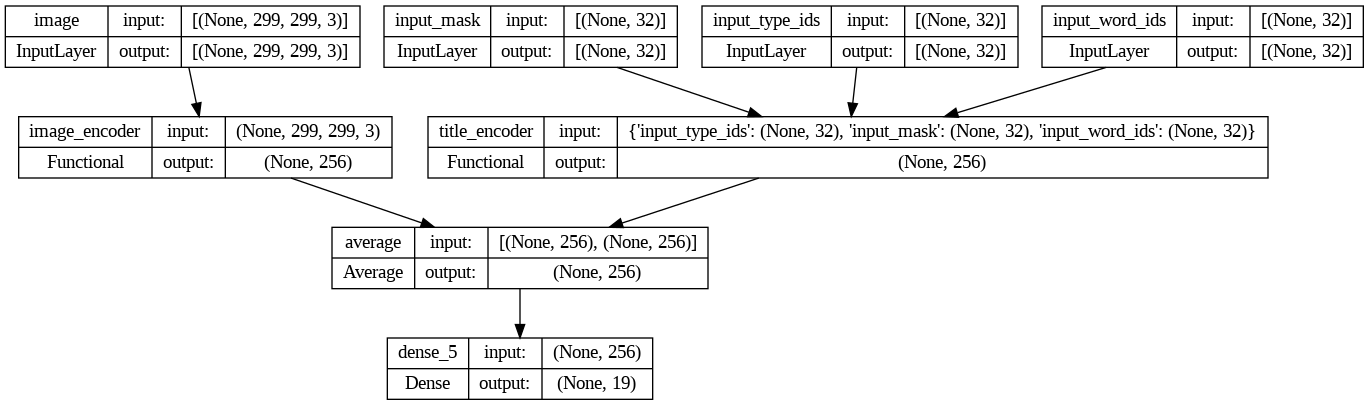

In [27]:
def create_multimodal_model(
    num_projection_layers=1,
    projection_dims=256,
    dropout_rate=0.1,
    vision_trainable=False,
    text_trainable=False,
):
    # Receive the images as inputs.
    image = keras.Input(shape=(299, 299, 3), name="image")

    # Receive the text as inputs.
    bert_input_features = ["input_type_ids", "input_mask", "input_word_ids"]
    text_inputs = {
        feature: keras.Input(shape=(32,), dtype=tf.int32, name=feature)
        for feature in bert_input_features
    }

    # Create the encoders.
    image_encoder = create_image_encoder(
        num_projection_layers, projection_dims, dropout_rate, vision_trainable
    )
    title_encoder = create_title_encoder(
        num_projection_layers, projection_dims, dropout_rate, text_trainable
    )

    # Fetch the embedding projections.
    image_projections = image_encoder(image)
    title_projections = title_encoder(text_inputs)

    # Concatenate the projections and pass through the classification layer.
    concatenated = keras.layers.Average()([image_projections, title_projections])
    outputs = keras.layers.Dense(lookup.vocabulary_size(), activation="sigmoid")(concatenated)

    return keras.Model([image, text_inputs], outputs)


multimodal_model = create_multimodal_model()
keras.utils.plot_model(multimodal_model, show_shapes=True)

In [28]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
#create callback that save model's weight
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

multimodal_model.compile(
    optimizer = "adam",
    loss = "binary_crossentropy",
    metrics = ["binary_accuracy", F1Score(average="micro", name="F1Score"), AUC(multi_label=True, num_labels=19, name="AUC")]
)

history = multimodal_model.fit(train_ds, validation_data=val_ds, epochs=8, callbacks=[cp_callback])

Epoch 1/8
111/111 [==============================] - ETA: 0s - loss: 0.2549 - binary_accuracy: 0.9074 - F1Score: 0.2844 - AUC: 0.4797
Epoch 1: saving model to training_1/cp.ckpt
111/111 [==============================] - 686s 6s/step - loss: 0.2549 - binary_accuracy: 0.9074 - F1Score: 0.2844 - AUC: 0.4797 - val_loss: 0.2441 - val_binary_accuracy: 0.9120 - val_F1Score: 0.3275 - val_AUC: 0.5772
Epoch 2/8
111/111 [==============================] - ETA: 0s - loss: 0.2341 - binary_accuracy: 0.9141 - F1Score: 0.3426 - AUC: 0.5695
Epoch 2: saving model to training_1/cp.ckpt
111/111 [==============================] - 587s 5s/step - loss: 0.2341 - binary_accuracy: 0.9141 - F1Score: 0.3426 - AUC: 0.5695 - val_loss: 0.2321 - val_binary_accuracy: 0.9153 - val_F1Score: 0.3625 - val_AUC: 0.6605
Epoch 3/8
111/111 [==============================] - ETA: 0s - loss: 0.2162 - binary_accuracy: 0.9191 - F1Score: 0.3953 - AUC: 0.6614
Epoch 3: saving model to training_1/cp.ckpt
111/111 [=====================

In [29]:
test_df.iloc[34:36]

,idx,titles,img_path,genres
id,,,,
2069,2069,"Trip to Bountiful, The",./data/posters/2069.jpg,[Drama]
1834,1834,"Spanish Prisoner, The",./data/posters/1834.jpg,"[Drama, Thriller]"


In [30]:
test_sample = prepare_dataset(test_df.iloc[10:12])
res = multimodal_model.predict(test_sample)
res

1/1 [==============================] - 4s 4s/step


array([[8.18246262e-05, 8.49158823e-01, 2.22832590e-01, 1.31856427e-02,
        3.13489623e-02, 1.40598461e-01, 4.66975663e-03, 1.08517492e-02,
        2.00349018e-01, 1.85030419e-02, 2.44085887e-03, 5.09291664e-02,
        8.78178980e-03, 5.98791474e-03, 4.54946840e-03, 2.17152806e-03,
        5.85597055e-03, 3.44634093e-02, 1.80037844e-03],
       [2.61814275e-05, 7.77265608e-01, 1.14635199e-01, 1.87685117e-02,
        1.69170693e-01, 1.82152733e-01, 4.55673039e-03, 2.16514687e-03,
        5.13925264e-03, 7.22600496e-04, 2.63029374e-02, 1.38906045e-02,
        1.15908741e-03, 2.87170376e-04, 1.20918676e-02, 4.83738957e-03,
        4.05913545e-03, 1.62539806e-03, 1.72961515e-03]], dtype=float32)

Evaluate the model

In [31]:
_, acc, f1, auc = multimodal_model.evaluate(test_ds)
print(f"Binary Accuracy on the test set: {round(acc * 100, 2)}%")
print(f"F1-Score on the test set: {round(f1, 2)}")
print(f"AUC on the test set: {round(auc, 2)}")

10/10 [==============================] - 66s 7s/step - loss: 0.1879 - binary_accuracy: 0.9270 - F1Score: 0.4625 - AUC: 0.7627
Binary Accuracy on the test set: 92.7%
F1-Score on the test set: 0.46
AUC on the test set: 0.76


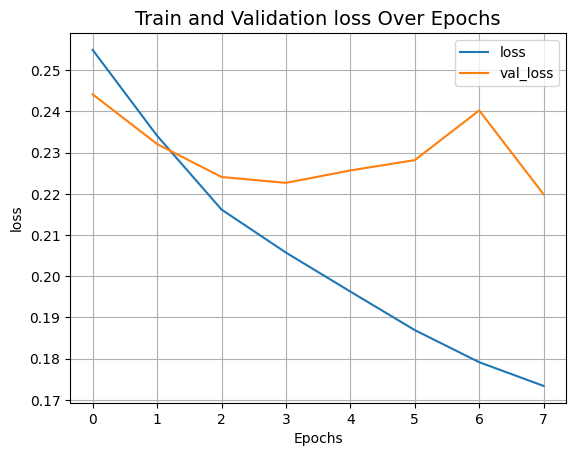

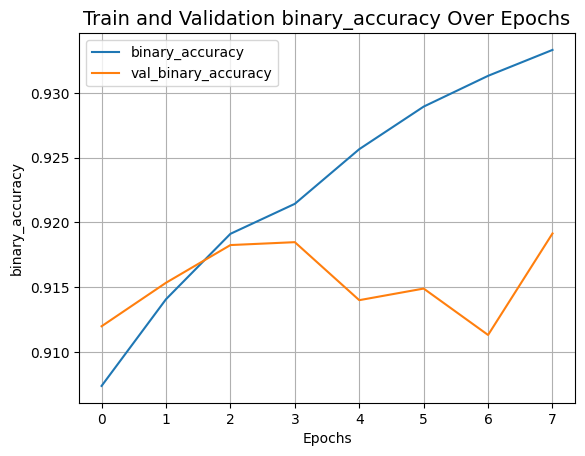

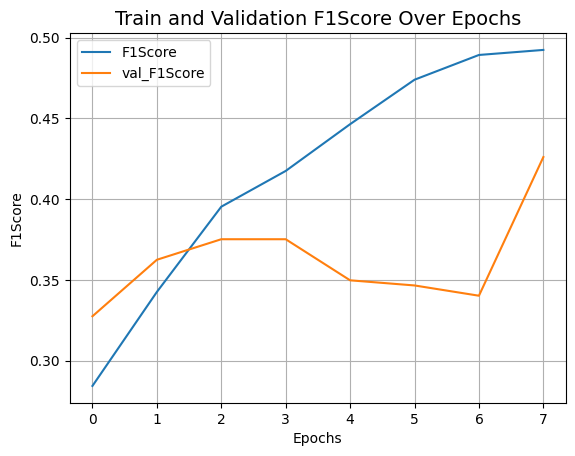

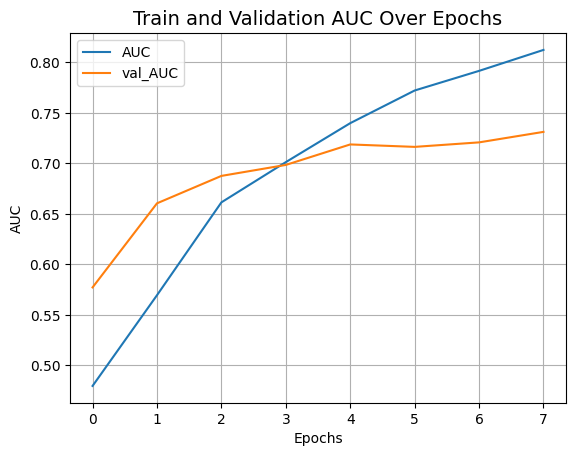

In [32]:
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("binary_accuracy")
plot_result("F1Score")
plot_result("AUC")

In [38]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
best_threshold = 0
label_pred = multimodal_model.predict(prepare_dataset(test_df))
label_true = lookup(tf.ragged.constant(test_df['genres'].values)).numpy()
thresholds = np.arange(0.1, 1, 0.05)

best_threshold = 0

best_f1 = 0

for threshold in thresholds:
    label_pred = np.where(label_pred > threshold, 1, 0)
    # Calculate the F1 score for the current threshold
    f1 = f1_score(label_true, label_pred, average='weighted')
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold
best_threshold
print("-----")
print(best_threshold)
# print(label_true.shape)
# print(label_pred.shape)
# label_pred
label_pred = np.where(label_pred > best_threshold, 1, 0)

# report = classification_report(label_true, label_pred, target_names=vocab)
# print(report)

10/10 [==============================] - 64s 6s/step
-----
0.1


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-

In [34]:
test_sample = prepare_dataset(test_df.iloc[10:12])
# res = multimodal_model.predict(test_sample)
# res = np.where(res > best_threshold, 1, 0)
test_sample

<_PrefetchDataset element_spec=({'image': TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), 'title': {'input_word_ids': TensorSpec(shape=(None, 32), dtype=tf.int32, name=None), 'input_type_ids': TensorSpec(shape=(None, 32), dtype=tf.int32, name=None), 'input_mask': TensorSpec(shape=(None, 32), dtype=tf.int32, name=None)}}, TensorSpec(shape=(None, 19), dtype=tf.float32, name=None))>

In [66]:
id = 35
test_df.iloc[id]

idx                            1834
titles        Spanish Prisoner, The
img_path    ./data/posters/1834.jpg
genres            [Drama, Thriller]
Name: 1834, dtype: object

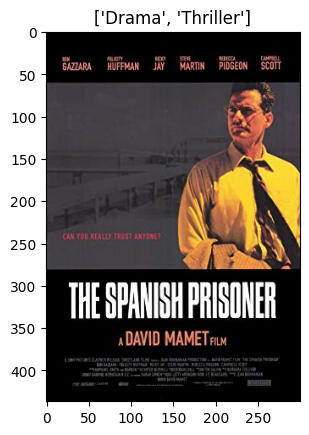

In [68]:
import cv2
img_path = test_df.iloc[id].img_path
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.title(test_df.iloc[id].genres)
plt.show()

In [69]:
test_sample = prepare_dataset(test_df.iloc[id:id+1])
res = multimodal_model.predict(test_sample)
res = np.where(res > best_threshold, 1, 0)
res

1/1 [==============================] - 1s 1s/step


array([[0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [71]:
# vocab
for index, value in enumerate(res[0]):
  if value == 1:
    print(vocab[index])

Drama
Comedy
Thriller
Romance


In [78]:
def visual_result(id_test):
  img_path = test_df.iloc[id_test].img_path
  image = cv2.imread(img_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  plt.imshow(image)
  plt.title(test_df.iloc[id_test].genres)

  test_sample = prepare_dataset(test_df.iloc[id_test:(id_test+1)])
  res = multimodal_model.predict(test_sample)
  res = np.where(res > best_threshold, 1, 0)
  # print(res)
  film = []
  for index, value in enumerate(res[0]):
    if value == 1:
      film.append(vocab[index])
  print(f'Tên phim: {test_df.iloc[id_test].titles}')
  print(f'Thể loại phim: {test_df.iloc[id_test].genres}')
  print(f'Kết quả dự đoán thể loại film: {film}')

  plt.show()


1/1 [==============================] - 1s 1s/step
Tên phim: Spanish Prisoner, The
Thể loại phim: ['Drama', 'Thriller']
Kết quả dự đoán thể loại film: ['Drama', 'Comedy', 'Thriller', 'Romance']


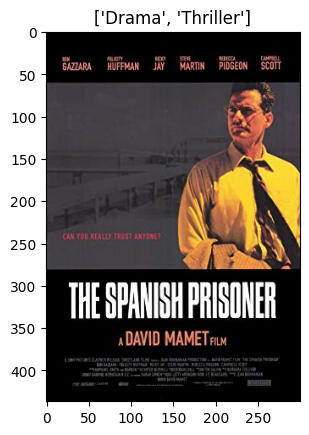

In [87]:
visual_result(35)